In [1]:
import numpy as np
import datetime
from IPython.display import SVG
from keras.datasets import mnist
from keras import activations
from keras import backend as K
from keras.layers import Dense, Input, concatenate, Conv1D, Conv2D, Dropout, MaxPooling1D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential, load_model
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from matplotlib import gridspec
from matplotlib.ticker import NullFormatter, NullLocator, MultipleLocator
from scipy import stats
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from vis.utils import utils
from vis.visualization import visualize_activation
from vis.visualization import visualize_saliency
import datetime
import keras
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import talos as ta
sns.set_palette('husl')
sns.set(style = 'ticks')

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 8]

In [3]:
df = pd.read_csv(
    "SUSY_100k.csv",
    names = [
        "classification",
        "lepton_1_pT",
        "lepton_1_eta",
        "lepton_1_phi",
        "lepton_2_pT",
        "lepton_2_eta",
        "lepton_2_phi",
        "missing_energy_magnitude",
        "missing_energy_phi",
        "MET_rel",
        "axial_MET",
        "M_R",
        "M_TR_2",
        "R",
        "MT2",
        "S_R",
        "M_Delta_R",
        "dPhi_r_b",
        "cos_theta_r1"
    ]
)
df_raw = df
df.head()

,classification,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


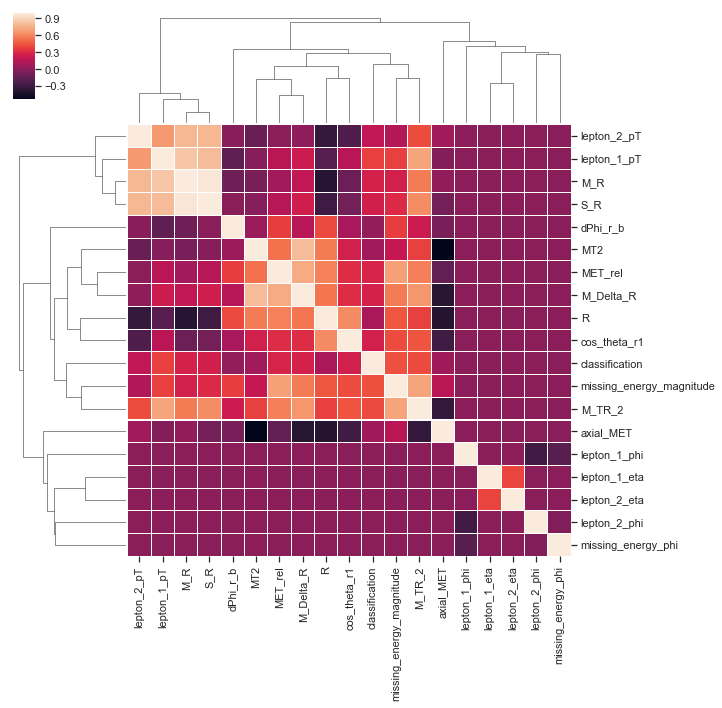

In [4]:
#hierarchically-clustered correlations
plot = sns.clustermap(df.corr(), linewidths=0.1)
hierarchically_clustered_features = plot.data2d.columns
df = df[hierarchically_clustered_features.tolist()]
_ = plt.setp(plot.ax_heatmap.get_yticklabels(), rotation = 0)

In [5]:
df['labels'] = df['classification'].astype('category').cat.codes
x = df.drop(columns = ['classification', 'labels']).values.astype('float32')
y = df['classification']
num_classes = len(y.unique())
y_raw = y # non-categorical

x = np.asarray(x)
y = np.asarray(y)

x = x.reshape(len(x), 18, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)

# Convert class vectors to binary class matrices using 1 hot encoding.
# 0 ---> 1, 0
# 1 ---> 0, 1
y_cat   = keras.utils.to_categorical(y, len(y_raw.unique()))
y_train = keras.utils.to_categorical(y_train, len(y_raw.unique()))
y_test  = keras.utils.to_categorical(y_test,  len(y_raw.unique()))

In [6]:
#model = Sequential()
#model.add(Conv1D(32, (5), strides=(1), input_shape=(18, 1), activation='tanh'))
#model.add(MaxPooling1D(pool_size=(2), strides=(2)))
#model.add(Conv1D(32, (3), strides=(1), activation='tanh'))
#model.add(Flatten())
#model.add(Dense(300, activation='tanh'))
#model.add(Dropout(rate=0.5))
#model.add(Dense(300, activation='tanh'))
#model.add(Dropout(rate=0.5))
#model.add(Dense(num_classes, activation='softmax', name="preds"))
#model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=['accuracy'])
##plot_model(model, to_file="model.png")
#model.summary()
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
#model = Sequential()
#model.add(Dense(300, input_shape = (18, 1),                     activation = 'tanh'))
#model.add(Conv1D(32, (5), strides = (1), input_shape = (18, 1), activation = 'tanh'))
#model.add(MaxPooling1D(pool_size = (2), strides = (2)))
#model.add(Conv1D(32, (3), strides = (1), input_shape = (18, 1), activation = 'tanh'))
##model.add(Dropout(rate = 0.5))
#model.add(Flatten())
#model.add(Dense(300,                                            activation = 'tanh'))
##model.add(Dropout(rate = 0.5))
#model.add(Dense(300,                                            activation = 'tanh'))
#model.add(Dropout(rate = 0.5))
#model.add(Dense(num_classes,                                    activation = 'softmax', name = "preds"))
#model.compile(loss = "categorical_crossentropy", optimizer = "nadam", metrics = ['accuracy'])
##plot_model(model, to_file="model.png")
#model.summary()
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 18, 1)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 18, 500)      1000        input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 18, 500)      0           dense_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 18, 144)      72144       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_3 (

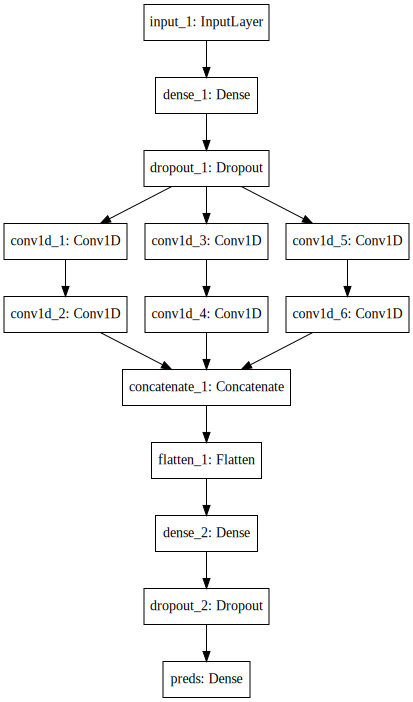

In [8]:
inputs  = Input((18, 1))
x       = Dense(500,       activation='tanh')(inputs)
x       = Dropout(rate=0.7)(x)
tower_1 = Conv1D(144, (1), activation='tanh', border_mode='same')(x)
tower_1 = Conv1D(144, (3), activation='tanh', border_mode='same')(tower_1)
tower_2 = Conv1D(144, (1), activation='tanh', border_mode='same')(x)
tower_2 = Conv1D(144, (3), activation='tanh', border_mode='same')(tower_2)
tower_3 = Conv1D(144, (1), activation='tanh', border_mode='same')(x)
tower_3 = Conv1D(144, (5), activation='tanh', border_mode='same')(tower_3)
x       = concatenate([tower_1, tower_2, tower_3], axis=2)
x       = Flatten()(x)
x       = Dense(500,       activation='tanh')(x)
x       = Dropout(rate=0.7)(x)
preds   = Dense(num_classes, activation='softmax', name='preds')(x)
model   = Model(input=inputs, output=preds)
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [9]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs = {}):
        self.acc = []
        self.val_acc = []
    def on_epoch_end(self, batch, logs = {}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
history = AccuracyHistory()

checkpoint_continuous = keras.callbacks.ModelCheckpoint(
    filepath       = 'best_model.{epoch:02d}-{val_loss:.2f}.h5',
    monitor        = 'val_loss',
    save_best_only = True
)

checkpoint_latest = keras.callbacks.ModelCheckpoint(
    filepath       = 'model_latest.h5',
    monitor        = 'val_loss',
    save_best_only = True
)

"""
tensorboard --logdir /tmp/TensorBoard
http://127.0.1.1:6006
"""
layer_names = [layer['config']['name'] for layer in model.get_config()]
callback_TensorBoard = keras.callbacks.TensorBoard(
    log_dir        ='/tmp/TensorBoard',
    histogram_freq = True,  
    write_graph    = True,
    write_images   = True,
    embeddings_layer_names = layer_names,
)

def model_evaluation(model, x_test, y_test, verbose=False):
    score = model.evaluate(x_test, y_test, verbose=verbose)
    #print('test loss:', score[0])
    #print('test accuracy:', score[1])
    #plt.plot(history.acc, label='train')
    #plt.plot(history.val_acc, label='validate')
    #plt.legend()
    #plt.xlabel('epochs')
    #plt.ylabel('accuracy')
    #plt.show()
    print('max. test accuracy observed:', max(model.history.history['val_acc']))
    print('max. test accuracy history index:', model.history.history['val_acc'].index(max(model.history.history['val_acc'])))
    plt.plot(model.history.history['acc'])
    plt.plot(model.history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

max. test accuracy observed: 0.7939000000317892
max. test accuracy history index: 1106


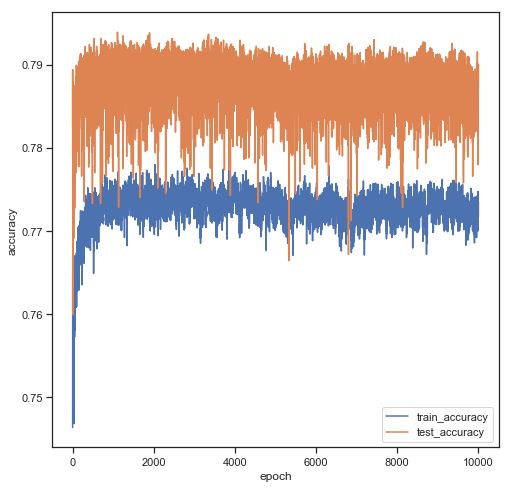

CPU times: user 19h 35min 38s, sys: 2h 58min 29s, total: 22h 34min 8s
Wall time: 19h 54min 5s


In [10]:
%%time

model.fit(
    x_train,
    y_train,
    batch_size      = 128,
    epochs          = 10000,
    verbose         = False,
    validation_data = (x_test, y_test),
    callbacks       = [history, checkpoint_latest]#, callback_TensorBoard]
)
model_evaluation(model, x_test, y_test, verbose=False)

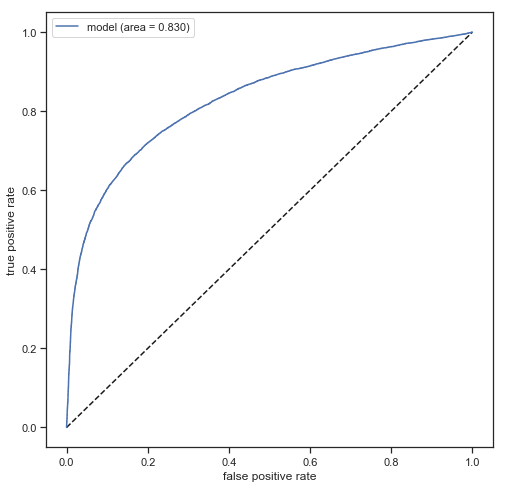

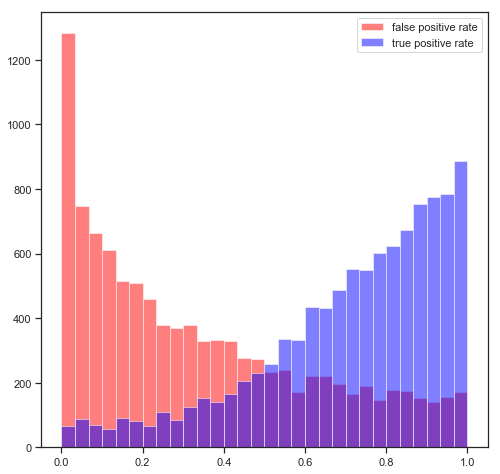

In [11]:
layer_idx = utils.find_layer_idx(model, 'preds')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

y_pred = model.predict(x_test)
y_test_non_categorical = np.argmax(y_test, axis=1)
y_pred_non_categorical = np.argmax(y_pred, axis=1)
fpr, tpr, thresholds = roc_curve(y_test_non_categorical, y_pred[:,1])
auc_data = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='model (area = {:.3f})'.format(auc_data))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
#plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.hist(fpr, bins=30, color='red',  alpha=0.5, label='false positive rate')
plt.hist(tpr, bins=30, color='blue', alpha=0.5, label='true positive rate')
plt.legend(loc='best')
plt.show();

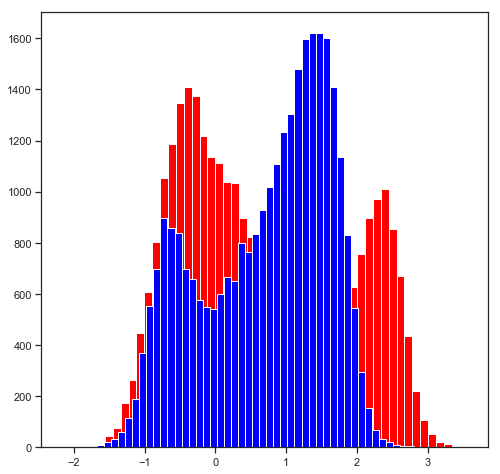

In [12]:
plt.hist(y_pred[:,1], color='red',  bins=50)
plt.hist(y_pred[:,0], color='blue', bins=50);